<font size="8"> **Calculating mean environmental conditions from ACCESS-OM2-01 outputs during crabeater weaning period** </font>  
Here, we will calculate the mean environmental conditions crabeaters experienced in East Antarctica during the weaning period (for the period for which we have crabeater data) from ACCESS-OM2-01 model outputs. We will use this information to estimate the distribution of crabeater seals during their weaning period.

# Setting working directory
In order to ensure these notebooks work correctly, we will set the working directory. We assume that you have saved a copy of this repository in your home directory (represented by `~` in the code chunk below). If you have saved this repository elsewhere in your machine, you need to ensure you update this line with the correct filepath where you saved these notebooks.

In [1]:
import os
os.chdir(os.path.expanduser('~/Chapter2_Crabeaters/Scripts'))

# Loading other relevant libraries

In [2]:
from dask.distributed import Client
from glob import glob
#Accessing model data
import cosima_cookbook as cc
#Useful functions
import UsefulFunctions as uf
#Dealing with data
import xarray as xr
import pandas as pd
import numpy as np
#Data visualisation
import matplotlib.pyplot as plt

# Paralellising work 

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40559/status,
Dashboard: /proxy/40559/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36727,Workers: 7
Dashboard: /proxy/40559/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:38471,Total threads: 2
Dashboard: /proxy/32951/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:36239,


# Getting date range from crabeater seal observations
We will calculate the mean conditions of every over the period for which we have crabeater observations. The weaning period happens between November and December.

In [4]:
#Loading dataset as pandas data frame
crabeaters = pd.read_csv('../Biological_Data/unique_crabeater_obs_grid.csv')

#Selecting weaning period
crabeaters = crabeaters[crabeaters.life_stage == 'weaning']

#Print minimum and maximum years
print(crabeaters.year.min(), crabeaters.year.max())

1981 2022


To calculate mean conditions, we will extract data for November and December between 1981 and 2022.

# Loading Indian sectors mask
Since our area of interest includes the East and Central Indian sectors, we will apply a mask to the data prior to calculating the mean for each variable.

In [13]:
#All variables except velocity
measo = xr.open_dataarray('/g/data/v45/la6889/Chapter2_Crabeaters/MEASO/MEASO_mask.nc')
#Renaming dimensions to match model data
measo = measo.rename({'lat': 'yt_ocean', 'lon': 'xt_ocean'}).sel(yt_ocean = slice(-90, -45))

#Checking result
measo

<xarray.DataArray 'mask' (yt_ocean: 713, xt_ocean: 3600)>
[2566800 values with dtype=float64]
Coordinates:
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0

## Loading keys to identify the East and Central Indian sectors
The MEASO mask includes all sectors within the Southern Ocean. Here we print the keys on the screen to identify the numeric ID given to all zones (Antarctic, Subantarctic and Northern) included within the Central and East Indian sectors.

In [9]:
#Loading keys
measo_key = pd.read_csv('/g/data/v45/la6889/Chapter2_Crabeaters/MEASO/MEASO_keys.csv')
#Identifying Indian sectors
measo_key[measo_key.LongName.str.contains('Indian')]

,name,LongName,ID
9,CIA,Central Indian Antarctic,13
10,CIS,Central Indian Subantarctic,14
11,CIN,Central Indian Northern,15
12,EIA,East Indian Antarctic,17
13,EIS,East Indian Subantarctic,18
14,EIN,East Indian Northern,19


## Creating mask for the Indian sectors only
We will use the `ID` column to select the Indian sectors only. Our maximum latitudinal range is $55^{\circ}S$, as we do not expect crabeaters to occupy open water areas offshore during the weaning period.

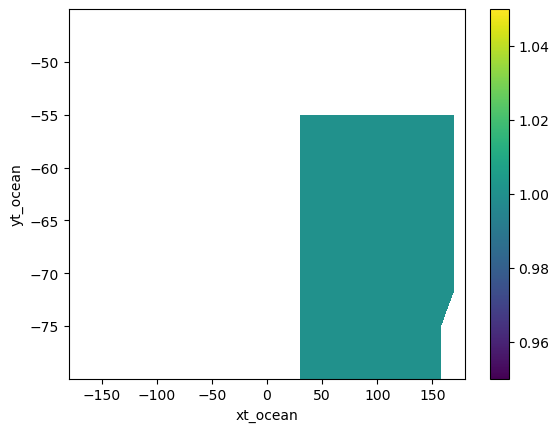

In [14]:
#Subsetting both masks
measo_ind = xr.where((measo >= 13) & (measo <= 19) & (measo.yt_ocean <= -55), 1, np.nan)
#Checking results
measo_ind.plot()

In [11]:
#Full path to static variables
base_dir_static = '/g/data/v45/la6889/Chapter2_Crabeaters/Static_Variables/'

#List of static variables
varDict = {'bottom_slope_deg': 'bathy_slope_GEBCO_2D.nc',
           'dist_shelf_km': 'distance_shelf.nc',
           'dist_coast_km': 'distance_coastline.nc',
           'depth_m': 'bathy_GEBCO_2D.nc'}

# Extracting data for each observation and adding it to a new column in crabeater data

In [12]:
#Looping through dictionary keys
for i, var in enumerate(varDict):
    #Creating full path to file of interest
    file_path = os.path.join(base_dir_static, varDict[var])
    #Load as raster
    ras = xr.open_dataarray(file_path)
    #Apply mask
    ras = ras.where(measo_ind == 1, drop = True)
    #Convert to data frame
    ras = ras.to_series().dropna().reset_index()
    #Round coordinate values
    ras = ras.round({'yt_ocean': 3, 'xt_ocean': 3})
    #Renaming masked data before merging to observations
    ras = ras.rename(columns = {ras.columns[-1]: var})
    #Creating data frame with data
    if i == 0:
        static_vars = ras
    else:
        static_vars = static_vars.merge(ras, on = ['yt_ocean', 'xt_ocean'], how = 'left')
    
#Checking results
static_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m
0,-71.478,169.95,89.944382,-135.524276,1.609834,206.816666
1,-71.436,169.65,89.972290,-139.029088,10.654348,209.966660
2,-71.436,169.75,89.965401,-136.600358,7.133048,273.299957
3,-71.436,169.85,89.950462,-134.225430,3.646842,282.933319
4,-71.436,169.95,89.920975,-131.907215,0.878910,282.933319
...,...,...,...,...,...,...
365117,-55.010,169.55,89.996086,1295.364889,1074.993849,1732.154785
365118,-55.010,169.65,89.995605,1298.487513,1077.094208,2341.309570
365119,-55.010,169.75,89.995438,1301.625629,1079.219248,3181.023926
365120,-55.010,169.85,89.995171,1304.779118,1081.368816,3793.833252


# Saving results

In [13]:
static_vars.to_csv('../Environmental_Data/All_values_static_vars.csv', index = False)

# Accessing ACCESS-OM2-01 model outputs
We will create a new `cosima cookbook` session to load the model outputs of interest, and we will also create a dictionary that contains useful information related to data extraction.

In [6]:
#Creating new COSIMA cookbook session
session = cc.database.create_session()

In [22]:
#Creating dictionary with useful information
varDict = {'model': 'ACCESS-OM2-01',
           #ACCESS-OM2-01 cycle 4 (1958-2018)
           'exp': '01deg_jra55v140_iaf_cycle4',
           #Temporal resolution
           'freq': '1 monthly',
           #Output folder
           'base_out': '../Environmental_Data/ACCESS-OM2-01',
           #Variable name in the model
           'var_mod': 'krill_ggp',
           #Name of column where we will store the extracted data
           'var_short_name': 'krill_ggp',
           #Defining if this variable is related to sea ice or not
           'ice_data': False}

#Checking final dictionary
varDict

{'model': 'ACCESS-OM2-01',
 'exp': '01deg_jra55v140_iaf_cycle4',
 'freq': '1 monthly',
 'base_out': '../Environmental_Data/ACCESS-OM2-01',
 'var_mod': 'krill_ggp',
 'var_short_name': 'krill_ggp',
 'ice_data': False}

# Loading data from ACCESS-OM2-01
ACCESS-OM2-01 has four different cycles available with a temporal range of 60 years (1958-2018), but only cycle 4 includes biogeochemical (BGC) outputs. Since we are interested in examining the effect of some BGC variables on crabeater seals, we will use the fourth cycle in this project. The crabeater dataset for East Antarctica has temporal range between 1981 and 2013.  
  
In the chunk below, we load the ACCESS-OM2-01 data, correct longitudes so they range between -180 and +180, and apply a transformation to temperature outputs (`temp`) only because the original units are in Kelvin and we need them in $^{\circ}C$.

In [32]:
#Loading data from fourth cycle (temporal range 1958 to 2018)
var_df = uf.getACCESSdata_SO(varDict['var_mod'], '1981-11', '2014-01', 
                              freq = varDict['freq'], ses = session, minlat = -80,
                              exp = varDict['exp'], ice_data = varDict['ice_data'])

#Ensuring data is selected for the time period of interest
var_df = var_df.sel(time = slice('1981-11', '2013-12'))

#Transforming longitudes so their range is +/-180 degrees
var_df = uf.corrlong(var_df)

# #If temperature data, transform from Kelvin to degrees C
if var_df.name == 'temp':
    var_df = var_df-273.15

#Checking result
var_df

<xarray.DataArray 'salt' (time: 386, st_ocean: 75, yt_ocean: 713, xt_ocean: 3600)>
dask.array<getitem, shape=(386, 75, 713, 3600), dtype=float32, chunksize=(1, 19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 1981-11-16 ... 2013-12-16T12:00:00
Attributes: (12/13)
    long_name:      Practical Salinity
    units:          psu
    valid_range:    [-10. 100.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    ...             ...
    ncfiles:        ['/g/data/cj50/access-om2/raw-output/access-om2-01/01deg_...
    contact:        Andrew Kiss
    email:          andrew.kiss@anu.edu.au
    created:        2022-04-27
    description:    0.1 degree ACCESS-OM2 global model configuration under in...
    notes:          Run configuration and history: https://github.com/COSIMA/...

## *Optional: Subsetting surface layer data*
For some ocean variables, we need to subset data to extract surface values or bottom values. Subsetting data for the surface layer is an easy process, we simply need to select the first depth bin available. The `st_ocean` dimension contains the depth bins.

In [9]:
#Selecting the first depth available in the model (i.e. surface layer)
var_df = var_df.isel(st_ocean = 0)

#Removing depth dimension
var_df = var_df.squeeze().drop('st_ocean')

#Checking results - dataset has three dimensions instead of the original four
var_df

<xarray.DataArray 'temp' (time: 386, yt_ocean: 713, xt_ocean: 3600)>
dask.array<getitem, shape=(386, 713, 3600), dtype=float32, chunksize=(1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
  * time      (time) datetime64[ns] 1981-11-16 ... 2013-12-16T12:00:00

## *Optional: Subsetting bottom data*
Subsetting data for the bottom layer is not as straightforward as for the surface. This is because the bathymetry is not the same across the Southern Ocean. To identify the correct depth bin that contains the deepest values for a particular grid cell.  
  
We have included a function called `extract_bottom_layer` in the `UsefulFunctions.py` script that extracts data for the bottom layer of any variables with a depth dimension (`st_ocean`). For more details refer to the script.  

In [33]:
var_df = uf.extract_bottom_layer(var_df)
#Checking results
var_df

<xarray.DataArray 'salt' (time: 386, yt_ocean: 713, xt_ocean: 3600)>
dask.array<transpose, shape=(386, 713, 3600), dtype=float64, chunksize=(1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -179.9 -179.8 -179.7 ... 179.8 179.9 180.0
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -45.18 -45.11 -45.04
  * time      (time) datetime64[ns] 1981-11-16 ... 2013-12-16T12:00:00

# Loading other dynamic variables derived from calculations or regridded
These variables are not directly available in ACCESS-OM2-01, but they have been calculated from model outputs. Refer to folder `02_Environmental_Data` to see the full details of each calculation.

In [23]:
file_path = '/g/data/v45/la6889/Chapter2_Crabeaters/Krill_habitat/*ggp*.nc'
var_name = varDict['var_mod']

In [24]:
#Load data
var_df = xr.open_mfdataset(sorted(glob(file_path)))[var_name]
#Rechunking and selecting time period of interest
var_df = var_df.chunk((1, 135, 180)).sel(time = slice('1981-11', '2013-12'))
#If mask is present as dimension, drop it
if 'mask' in var_df.coords:
    var_df = var_df.squeeze().drop('mask')
#Check results
var_df

<xarray.DataArray 'krill_ggp' (time: 66, yt_ocean: 557, xt_ocean: 1400)>
dask.array<rechunk-merge, shape=(66, 557, 1400), dtype=float32, chunksize=(1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1981-11-16 1981-12-16 ... 2013-12-16
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -55.12 -55.07 -55.01
  * xt_ocean  (xt_ocean) float64 30.05 30.15 30.25 30.35 ... 169.8 169.9 170.0

# Calculating mean over time for weaning period
We will include data from 1981 to 2022. The weaning period includes the months of November and December.

In [25]:
#Identifying timesteps to be included in calculations
mean_var = [da for m, da in var_df.groupby('time.month') if m in [11, 12]]
#Concatenating into single data array, calculate monthly mean over entire time period and apply mask
mean_var = xr.concat(mean_var, dim = 'time').groupby('time.month').mean('time').where(measo_ind == 1, drop = True)
#Checking results
mean_var

<xarray.DataArray 'krill_ggp' (month: 2, yt_ocean: 557, xt_ocean: 1400)>
dask.array<where, shape=(2, 557, 1400), dtype=float32, chunksize=(1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * yt_ocean  (yt_ocean) float64 -79.97 -79.93 -79.88 ... -55.12 -55.07 -55.01
  * xt_ocean  (xt_ocean) float64 30.05 30.15 30.25 30.35 ... 169.8 169.9 170.0
  * month     (month) int64 11 12

## Transform into data frame

In [26]:
#Converting to pandas data frame
var_pd = mean_var.to_series().dropna().reset_index()
#Round coordinate values
var_pd = var_pd.round({'yt_ocean': 3, 'xt_ocean': 3})
#Renaming masked data before merging to observations
var_pd = var_pd.rename(columns = {varDict['var_mod']: varDict['var_short_name']})
#Checking results
var_pd.head()

,month,yt_ocean,xt_ocean,krill_ggp
0,11,-71.563,169.95,0.990715
1,11,-71.520,169.85,0.990754
2,11,-71.520,169.95,0.983524
3,11,-71.478,169.55,0.994107
4,11,-71.478,169.65,0.985743


## Adding mean calculations for dynamic environmental variables to data frame with static environmental data

In [31]:
#Loading file
env_vars = pd.read_csv('../Environmental_Data/All_values_static_vars.csv')
env_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m
0,-71.478,169.95,89.944382,-135.524276,1.609834,206.81667
1,-71.436,169.65,89.972290,-139.029088,10.654348,209.96666
2,-71.436,169.75,89.965401,-136.600358,7.133048,273.29996
3,-71.436,169.85,89.950462,-134.225430,3.646842,282.93332
4,-71.436,169.95,89.920975,-131.907215,0.878910,282.93332
...,...,...,...,...,...,...
365117,-55.010,169.55,89.996086,1295.364889,1074.993849,1732.15480
365118,-55.010,169.65,89.995605,1298.487513,1077.094208,2341.30960
365119,-55.010,169.75,89.995438,1301.625629,1079.219248,3181.02400
365120,-55.010,169.85,89.995171,1304.779118,1081.368816,3793.83330


In [31]:
#Getting number of times month has to be repeated
rows_month = env_vars.shape[0]

#Bind static variables by row
env_vars = pd.concat([env_vars, env_vars], axis = 0)

#Add a month column to bind data frame
env_vars['month'] = [11]*rows_month + [12]*rows_month

#Check results
env_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m,month
0,-71.478,169.95,89.944382,-135.524276,1.609834,206.81667,11
1,-71.436,169.65,89.972290,-139.029088,10.654348,209.96666,11
2,-71.436,169.75,89.965401,-136.600358,7.133048,273.29996,11
3,-71.436,169.85,89.950462,-134.225430,3.646842,282.93332,11
4,-71.436,169.95,89.920975,-131.907215,0.878910,282.93332,11
...,...,...,...,...,...,...,...
365117,-55.010,169.55,89.996086,1295.364889,1074.993849,1732.15480,12
365118,-55.010,169.65,89.995605,1298.487513,1077.094208,2341.30960,12
365119,-55.010,169.75,89.995438,1301.625629,1079.219248,3181.02400,12
365120,-55.010,169.85,89.995171,1304.779118,1081.368816,3793.83330,12


## Merging all variables together

In [28]:
#Getting column names for merging
cols = var_pd.drop(columns = varDict['var_short_name']).columns.tolist()

#Merging columns
env_vars = env_vars.merge(var_pd, on = cols, how = 'left')

#Checking results
env_vars

,yt_ocean,xt_ocean,bottom_slope_deg,dist_shelf_km,dist_coast_km,depth_m,month,freez_pot_Wm2,SIT_m,SIC,...,SSS_psu,bottom_sal_psu,vel_lat_surf_msec,vel_lat_bottom_msec,vel_lon_surf_msec,vel_lon_bottom_msec,lt_pack_ice,dist_ice_edge_km,krill_growth_rate,krill_ggp
0,-71.478,169.95,89.944382,-135.524276,1.609834,206.81667,11,-1127.0930,0.085305,0.514166,...,34.585228,34.685023,0.017858,0.024176,-0.000913,-0.004160,0.524170,-829.096611,-1.148979,0.977719
1,-71.436,169.65,89.972290,-139.029088,10.654348,209.96666,11,-1202.7275,0.048049,0.368097,...,34.588856,34.706097,0.034315,0.014881,-0.006845,-0.009560,0.513348,-827.423959,-1.146956,0.977782
2,-71.436,169.75,89.965401,-136.600358,7.133048,273.29996,11,-1398.8147,0.058411,0.392666,...,34.565693,34.728629,0.026299,0.013608,-0.003212,-0.006330,0.485570,-826.529172,-1.338134,0.973657
3,-71.436,169.85,89.950462,-134.225430,3.646842,282.93332,11,-1505.3706,0.080340,0.482283,...,34.557472,34.725980,0.022762,0.016096,0.001572,-0.001050,0.508297,-825.639647,-1.401296,0.972273
4,-71.436,169.95,89.920975,-131.907215,0.878910,282.93332,11,-1552.8070,0.103846,0.572968,...,34.553120,34.726696,0.017029,0.023090,0.003589,0.000731,0.545815,-824.737430,-1.417213,0.971925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
730239,-55.010,169.55,89.996086,1295.364889,1074.993849,1732.15480,12,-84282.4200,0.000000,0.000000,...,34.263885,34.722189,0.187000,0.055537,0.319311,0.056921,0.000000,986.392814,NaN,NaN
730240,-55.010,169.65,89.995605,1298.487513,1077.094208,2341.30960,12,-83943.0000,0.000000,0.000000,...,34.250250,34.758736,0.207875,0.039629,0.346709,0.038050,0.000000,987.306614,NaN,NaN
730241,-55.010,169.75,89.995438,1301.625629,1079.219248,3181.02400,12,-83545.3200,0.000000,0.000000,...,34.235798,34.734646,0.230287,0.014453,0.373622,0.013280,0.000000,988.232618,NaN,NaN
730242,-55.010,169.85,89.995171,1304.779118,1081.368816,3793.83330,12,-83073.7600,0.000000,0.000000,...,34.220165,34.710063,0.251984,0.005039,0.398821,0.003507,0.000000,989.186530,NaN,NaN


# Saving results

In [29]:
#Ensure output folder exists
os.makedirs(varDict['base_out'], exist_ok = True)

#Create file path where data will be saved
file_out = os.path.join(varDict['base_out'], 'All_values_month_ACCESS-OM2-01_env_vars.csv')

#Saving as csv file
env_vars.to_csv(file_out, index = False)